In [1]:
import requests
import pandas as pd
import googlemaps
import folium
import glob
import shutil
import requests
import os
import numpy as np
import datetime
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Intro

In [3]:
get_data = False
# get_data = True

In [4]:
API_GOOGLE = os.environ.get('GOOGLE_KEY')

In [337]:
req = requests.get('http://www.nemweb.com.au/REPORTS/ARCHIVE/Dispatch_SCADA/')

In [6]:
adf = pd.read_html('http://products.iesys.com/Data/Gensets')[0]

ValueError: No tables found

In [ ]:
adf

### Data sources

Australia has open access wind power generation data and also weather station data.
* [Weather station database](https://mesonet.agron.iastate.edu/request/download.phtml?network=AU__ASOS) 
* [Weather station meta](https://mesonet.agron.iastate.edu/sites/networks.php?network=AU__ASOS)
* [Wind power summary](http://www.whit.com.au/aemo-registered-participants/')
* [Wind power resource](http://www.nemweb.com.au/REPORTS/ARCHIVE/Dispatch_SCADA/)
* [Additional power summary](http://products.iesys.com/Data/Gensets)


In [343]:
import mechanize
from time import sleep
#Make a Browser (think of this as chrome or firefox etc)
br = mechanize.Browser()

#visit http://stockrt.github.com/p/emulating-a-browser-in-python-with-mechanize/
#for more ways to set up your br browser object e.g. so it look like mozilla
#and if you need to fill out forms with passwords.

# Open your site
br.open('http://www.nemweb.com.au/REPORTS/ARCHIVE/Dispatch_SCADA')

f=open("source.html","w")

filetypes=[".zip",".exe",".tar.gz"] #you will need to do some kind of pattern matching on your files
myfiles=[]
for l in br.links(): #you can also iterate through br.forms() to print forms on the page!
    for t in filetypes:
        if t in str(l): #check if this link has the file extension we want (you may choose to use reg expressions or something)
            myfiles.append(l)



In [47]:
base_path = 'http://www.nemweb.com.au/'
zip_dir = './data/power_zips/'
csv_dir = './data/power_csvs/'
# Took 30 minutes for ~300MB
if get_data:
    for path_url in myfiles:
        full_path = base_path + path_url.url
        req = requests.get(full_path)

        with open(os.path.join(zip_dir+path_url.text), 'wb') as f:
            f.write(req.content)

In [ ]:
if get_data:
    zips = os.listdir(zip_dir)
    zips = [z for z in zips if '.zip' in z]
    for z in zips:
        zip_ = ZipFile(os.path.join(zip_dir,z))
        zip_.extractall(path = os.path.join(zip_dir, z[:-4]))

        zip_list = os.listdir(os.path.join(zip_dir, z[:-4]))
        df_ = pd.concat([pd.read_csv(os.path.join(zip_dir,z[:-4], x), skiprows=1, skipfooter=1) for x in zip_list])
        df_.to_csv(os.path.join(csv_dir, z[:-4]+'.csv'))
        shutil.rmtree(os.path.join(zip_dir, z[:-4]))

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [882]:

def get_from_req(address, ):
    """A previously used function for finding lon/lat of locations"""
    ## Getting location using gmaps

    gmaps = googlemaps.Client(key=API_GOOGLE)
    gmaps_result = gmaps.geocode(address, bounds =   {"northeast":[0, 165],"southwest":[-50, 107]})

#     [print(i['formatted_address']) for i in gmaps_result]
    address = gmaps_result[0]['formatted_address']
    # Geocoding an address
    lon_lat = gmaps_result[0]['geometry']['location']
    lng = lon_lat['lng']
    lat = lon_lat['lat']
    location = [lng,lat]
    return location

In [575]:
x

'North Brown Hill Wind Farm'

In [574]:
get_from_req(x)

IndexError: list index out of range

In [570]:
station_info = pd.read_html('http://www.whit.com.au/aemo-registered-participants/')[0]
station_info=station_info[station_info.iloc[:,1]=='Wind']
# location_list = []
# for x in station_info.iloc[:,0].unique():
#     location_list.append(get_from_req(x))
location_list_t = []
for x in station_info.iloc[:,0].unique():
    location_list_t.append(get_from_req(x))

location_list_t_s = pd.Series(location_list_t, index = station_info.iloc[:,0].unique(), name = 'Location')

# Fixing some issues with google maps finding head offices rather than sites 
location_list_t_s.loc['Kiata Wind Farm'] =  [141.75, -36.4]
location_list_t_s.loc['Coonoer Bridge Wind Farm'] =[143.3603781, -36.4288307]
location_list_t_s.loc['Cathedral Rocks'] = [135.583333,-34.85 ]
station_info.loc[:,'location'] = location_list_t_s
station_info=station_info.merge(location_list_t_s, left_on = 'Power Station Name',right_index = True)
station_info.loc[:,'lat'] = station_info.Location.apply(lambda x: x[0])
station_info.loc[:,'lon'] = station_info.Location.apply(lambda x: x[1])
center = (station_info.lat.mean(),station_info.lon.mean())

IndexError: list index out of range

In [867]:
df_weather_s = pd.read_csv('./data/asos.txt', skiprows=0)
df_weather_s=df_weather_s.rename(columns = {'valid':'ob_time'})
df_weather_s.loc[:,'ob_time'] = pd.to_datetime(df_weather_s.loc[:,'ob_time'])
df_w_meta = df_weather_s[~df_weather_s.station.duplicated()].loc[:,['station','lon','lat']]

/home/james/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [582]:
m = folium.Map(location = center[::-1], zoom_start = 3)
for location_name, location in pd.Series.iteritems(location_list_t_s):
    m.add_child(folium.Marker(location[::-1], tooltip = location_name))
for idx in df_w_meta.index:
    m.add_child(folium.Marker(location = df_w_meta.loc[idx,['lat','lon']], 
                              tooltip = df_w_meta.loc[idx,['station']].values[0],
                              icon = folium.Icon(color = 'red', icon = 'cloud')))

m

In [584]:
def replace_M(x):
    if x =='M':
        return np.NaN
    else:
        return x

In [585]:
df_weather_s = df_weather_s.applymap(replace_M)

In [586]:
stations = df_weather_s.groupby('station')['sped'].count()>7000
stations=stations[stations].index

In [587]:
df_w_meta_red = df_w_meta[df_w_meta.station.isin(stations)]

### Active weather stations (2 < measurements per hour)

In [604]:
m = folium.Map(location = center[::-1], zoom_start = 3)
for location_name, location in pd.Series.iteritems(location_list_t_s):
    m.add_child(folium.Marker(location[::-1], tooltip = location_name))
for idx in df_w_meta_red.index:
    m.add_child(folium.Marker(location = df_w_meta_red.loc[idx,['lat','lon']], 
                              tooltip = df_w_meta_red.loc[idx,['station']].values[0],
                              icon = folium.Icon(color = 'red', icon = 'cloud')))

m

In [767]:
gdf_wf = gpd.GeoDataFrame(location_list_t_s.apply(lambda x: Point(x)), geometry = 'Location',crs=4326).to_crs(3310)
# df_w_meta_red.loc[:,['lon','lat']] = df_w_meta_red.loc[:,['lon','lat']].astype(np.float)
gdf_ws = gpd.GeoDataFrame(df_w_meta_red, geometry = gpd.points_from_xy(df_w_meta_red.lon,df_w_meta_red.lat), crs=4326).to_crs(3310).set_index('station')[['geometry']]
gdf_wf_full = gdf_wf
gdf_wf=gdf_wf.iloc[:,0]
gdf_ws=gdf_ws.iloc[:,0]

In [880]:
# gdf_ws.loc[:,'wf_closest'] = 
gdf_wf_full.loc[:,'wf_closest'] = gdf_wf.apply(lambda x: gdf_ws.index[(np.argmin([x.distance(y) for y in gdf_ws])) ])

gdf_wf_full.loc[:,'wf_distance_km'] = gdf_wf.apply(lambda x: (np.min([x.distance(y) for y in gdf_ws])/1000) )
gdf_wf_full = gdf_wf_full.sort_values('wf_distance_km')
gdf_wf_full.loc[:,'normed_dist'] = gdf_wf_full.loc[:,'wf_distance_km']/((gdf_wf_full.loc[:,'wf_distance_km']).mean())

In [881]:
gdf_wf_full

,Location,wf_closest,wf_distance,normed_dist,wf_distance_km
Boco Rock Wind Farm,POINT (-12448818.955 -430603.939),YCOM,29.784229,0.222827,29.784229
Yaloak South Wind Farm,POINT (-12941663.818 184838.674),YMAV,42.551564,0.318345,42.551564
Cullerin Range Wind Farm,POINT (-12333346.875 -402682.280),YSCB,44.437612,0.332455,44.437612
Capital Wind Farm,POINT (-12340425.562 -430969.613),YSCB,51.536809,0.385567,51.536809
Gunning Wind Farm,POINT (-12324139.842 -401622.823),YSCB,53.374146,0.399312,53.374146
Gullen Range Wind Farm,POINT (-12317201.801 -403064.601),YSCB,60.442658,0.452195,60.442658
Woodlawn Wind Farm,POINT (-12331172.739 -436271.788),YSCB,61.904441,0.463131,61.904441
Lake Bonney Stage 2 Windfarm,POINT (-13262497.794 716991.976),YMTG,64.180402,0.480158,64.180402
Lake Bonney Stage 3 Wind Farm,POINT (-13262497.794 716991.976),YMTG,64.180402,0.480158,64.180402
Canunda Wind Farm,POINT (-13262497.794 716991.976),YMTG,64.180402,0.480158,64.180402


In [873]:
location_list_t_s_t

,wf_closest,wf_distance,normed_dist,wf_distance_km,Location
Boco Rock Wind Farm,41,29.784229,0.222827,29.784229,POINT (149.12587 -36.57696)
Yaloak South Wind Farm,8,42.551564,0.318345,42.551564,POINT (144.24195 -37.71647)
Cullerin Range Wind Farm,32,44.437612,0.332455,44.437612,POINT (149.39907 -34.81802)
Capital Wind Farm,32,51.536809,0.385567,51.536809,POINT (149.51828 -35.16612)
Gunning Wind Farm,32,53.374146,0.399312,53.374146,POINT (149.42701 -34.69056)
Gullen Range Wind Farm,32,60.442658,0.452195,60.442658,POINT (149.45957 -34.61494)
Woodlawn Wind Farm,32,61.904441,0.463131,61.904441,POINT (149.57895 -35.09543)
Lake Bonney Stage 2 Windfarm,22,64.180402,0.480158,64.180402,POINT (140.38689 -37.73795)
Lake Bonney Stage 3 Wind Farm,22,64.180402,0.480158,64.180402,POINT (140.38689 -37.73795)
Canunda Wind Farm,22,64.180402,0.480158,64.180402,POINT (140.38689 -37.73795)


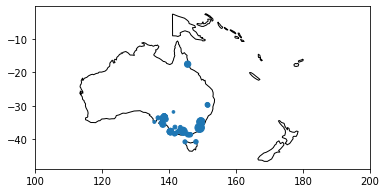

In [840]:
location_list_t_s_t = gdf_wf_full.iloc[:,1:].merge(location_list_t_s, left_index = True, right_index = True)
location_list_t_s_t.Location =location_list_t_s_t.Location .apply(lambda x: Point(x))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world=world[world.continent == 'Oceania']
base = world.plot(color='white', edgecolor='black')

gpd.GeoDataFrame(location_list_t_s_t, geometry = 'Location').plot(ax = base,  figsize=(12,6),markersize = 20/location_list_t_s_t.normed_dist)

plt.xlim([100,200]);

Going to select the 5 closest stations

In [843]:
good_wf = gdf_wf_full.head(5)

In [849]:
good_wf

,Location,wf_closest,wf_distance,normed_dist,wf_distance_km
Boco Rock Wind Farm,POINT (-12448818.955 -430603.939),41,29.784229,0.222827,29.784229
Yaloak South Wind Farm,POINT (-12941663.818 184838.674),8,42.551564,0.318345,42.551564
Cullerin Range Wind Farm,POINT (-12333346.875 -402682.280),32,44.437612,0.332455,44.437612
Capital Wind Farm,POINT (-12340425.562 -430969.613),32,51.536809,0.385567,51.536809
Gunning Wind Farm,POINT (-12324139.842 -401622.823),32,53.374146,0.399312,53.374146


In [866]:
df_weather_s.station.unique()

array(['YBMK', 'YGEL', 'YEML', 'YMDG', 'YPKG', 'YMEN', 'YGLA', 'YSNF',
       'YCBB', 'YAMB', 'YNBR', 'YMAV', 'YSRI', 'YPTN', 'YBNA', 'YBHM',
       'YBRM', 'YBBN', 'YPAD', 'YLEC', 'YCAS', 'YCFS', 'YOLD', 'YESP',
       'YPJT', 'YMER', 'YABA', 'YWLM', 'YCAR', 'YMHB', 'YMTG', 'YSTW',
       'YBDV', 'YGTH', 'YFRT', 'YWGT', 'YPWR', 'YBWX', 'YBAS', 'YNAR',
       'YNTN', 'YBOK', 'YMAY', 'YPPH', 'YBHI', 'YSCB', 'YBWP', 'YKRY',
       'YSWG', 'YBCS', 'YLIS', 'YHUG', 'YHID', 'YGFN', 'YMLT', 'YBTL',
       'YMIA', 'YCOM', 'YPEA', 'YNWN', 'YRMD', 'YTNK', 'YAYE', 'YPBO',
       'YBPN', 'YPXM', 'YSDU', 'YBCG', 'YPDN', 'YLHI', 'YBRK', 'YCCY',
       'YPCC', 'YLRE', 'YBLN', 'YCBP', 'YPGV', 'YCDU', 'YCNM', 'YMML',
       'YCIN', 'YPPD', 'YCBA', 'YARG', 'YPLM', 'YMEK', 'YMOR', 'YDBY',
       'YTEF', 'YGTE', 'YBUD', 'YBCV', 'YTRE', 'YSSY', 'YPKU', 'YSNW',
       'YPMQ', 'ANYN', 'YBMA', 'YWHA', 'YAYT'], dtype=object)

In [863]:
station_id

77     BOCORWF1
78     BOCORWF1
104    CULLRGWF
192    GUNNING1
239    CAPTL_WF
311       YSWF1
Name: Generator Unit Id, dtype: object

In [868]:
df_w = df_weather_s[df_weather_s.station.isin( station_id)]
df_w

,station,ob_time,lon,lat,tmpc,relh,drct,sped,alti,mslp,p01m,gust_mph,peak_wind_gust_mph,peak_wind_drct,peak_wind_time


In [865]:
station_id = station_info[station_info.loc[:,'Power Station Name'].isin(good_wf.index)]#.loc[:,'Generator Unit Id']
station_id


,Power Station Name,Fuel Type,Capacity (MW),Region,Generator Unit Id
77,Boco Rock Wind Farm,Wind,113.18,NSW1,BOCORWF1
78,Boco Rock Wind Farm,Wind,-,NSW1,BOCORWF1
104,Cullerin Range Wind Farm,Wind,30,NSW1,CULLRGWF
192,Gunning Wind Farm,Wind,46.5,NSW1,GUNNING1
239,Capital Wind Farm,Wind,140,NSW1,CAPTL_WF
311,Yaloak South Wind Farm,Wind,28.7,VIC1,YSWF1


In [589]:
df_w=df_w.applymap(replace_M)


For the 5 weather stations we have selected, they do not have any peak wind, gust data or mean sea level pressure data.

The columns with only a few hundred missing values we can fillna.

In [590]:
df_w=df_w.sort_values(['station','ob_time'])
df_w.loc[:,['tmpc', 'relh', 'drct', 'sped', 'alti', 'p01m']].fillna(method = 'ffill',inplace=True)

In [591]:
df_weather_s.peak_wind_gust_mph.value_counts()


Series([], Name: peak_wind_gust_mph, dtype: int64)

,station,ob_time,lon,lat,tmpc,relh,drct,sped,alti,mslp,p01m,gust_mph,peak_wind_gust_mph,peak_wind_drct,peak_wind_time
0,YBMK,2020-01-01 00:00:00,149.2169,-21.1172,30.00,66.15,130.00,10.35,29.91,M,0.0,M,M,M,M
1,YGEL,2020-01-01 00:00:00,114.6975,-28.7953,24.00,69.14,170.00,23.00,29.85,M,0.0,M,M,M,M
2,YEML,2020-01-01 00:00:00,148.1790,-23.5675,31.00,45.88,360.00,5.75,29.94,M,0.0,M,M,M,M
3,YMDG,2020-01-01 00:00:00,149.6110,-32.5625,32.00,27.56,320.00,6.90,29.94,M,0.0,M,M,M,M
4,YPKG,2020-01-01 00:00:00,121.4533,-30.7847,29.00,23.33,30.00,11.50,29.94,M,0.0,M,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921434,YSCB,2020-09-04 23:30:00,149.2003,-35.3088,13,58.27,310.00,10.35,30.06,M,0.0,M,M,M,M
921435,YPWR,2020-09-04 23:30:00,136.8054,-31.1558,17,36.45,120.00,6.90,30.18,M,0.0,M,M,M,M
921436,YPXM,2020-09-04 23:30:00,105.6875,-10.4528,24,83.32,130.00,13.80,29.94,M,0.0,M,M,M,M
921437,YMML,2020-09-04 23:30:00,144.8321,-37.6655,12,66.70,260.00,11.50,30.09,M,0.0,M,M,M,M


In [243]:
df_weather_s.groupby('station')['sped','gust_mph','peak_wind_gust_mph'].count().apply(lambda x: x.gust_mph/x.sped, axis=1).sort_values()

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


station
ANYN    0.001973
YBRK    0.002017
YBMK    0.002189
YBLN    0.003111
YBOK    0.003197
          ...   
YPPH    0.069679
YMEN    0.082888
YSNF    0.099943
YSNW    0.105096
YLHI    0.125846
Length: 101, dtype: float64

gust_mph has many missing values, because of design (?)

In [245]:
df_w.groupby('station')['lon'].count()

station
YBCS    13305
YBHI     5938
YCOM     8488
YMTG     8261
YSCB    13693
Name: lon, dtype: int64

In [283]:
df_temp = df_w[df_w.station == 'YBCS']
df_temp = df_w[df_w.station == 'YSCB']

df_temp.set_index('ob_time').resample("30T").count()["station"].value_counts()

Series([], Name: station, dtype: int64)

In [282]:
df_weather_s.groupby('station').count()['sped'].sort_values()

station
YAYT      274
ANYN     2027
YPMQ     2196
YARG     3751
YPBO     5170
        ...  
YHID    13723
YBHM    14018
YLHI    14041
YSNF    14108
YPXM    14982
Name: sped, Length: 101, dtype: int64

In [297]:
paired_dict #YBCS YSCB

{'Kiata Wind Farm': 'YSCB',
 'Windy Hill Wind Farm': 'YBCS',
 'Silverton Wind Farm': 'YBHI',
 'Boco Rock Wind Farm': 'YCOM',
 'Lake Bonney Stage 3 Wind Farm': 'YMTG'}

In [322]:
csvs = [csv for csv in os.listdir('./data/power_csvs') if '.csv'  in csv ]

In [380]:
len(csvs)

395

In [383]:
dfs = []
for csv in csvs:
    df = pd.read_csv(os.path.join('./data/power_csvs',csv))
    df = df[df.DUID.isin(['WHILL1', 'KIATAWF1'])]
    dfs.append(df)
df_power = pd.concat(dfs)

In [500]:
df_power_kia = df_power[df_power.DUID == 'KIATAWF1']
df_power_kia.rename(columns = {'SETTLEMENTDATE':'ob_time'}, inplace = True)
df_power_kia.loc[:,'ob_time'] = pd.to_datetime(df_power_kia.loc[:,'ob_time'])
df_power_kia=df_power_kia.set_index('ob_time').sort_index()
df_power_kia=df_power_kia.resample('30T').mean()

df_w_kia = df_w[df_w.station == 'YSCB'].set_index('ob_time')
df_w_kia = df_w_kia.sort_index()
df_w_kia.iloc[:,1:] = df_w_kia.iloc[:,1:].astype(np.float)
df_w_kia.iloc[:,:7]=df_w_kia.iloc[:,:7].fillna(method = 'ffill')
df_w_kia=df_w_kia.resample('30T').mean()

In [525]:
df_w_kia

,lon,lat,tmpc,relh,drct,sped,alti,mslp,p01m,gust_mph,peak_wind_gust_mph,peak_wind_drct,peak_wind_time
ob_time,,,,,,,,,,,,,
2020-01-01 00:00:00,149.2003,-35.3088,22.0,23.13,340.0,4.60,60.00,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,149.2003,-35.3088,23.0,23.39,280.0,4.60,30.00,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,149.2003,-35.3088,25.0,20.74,300.0,8.05,30.00,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-01 01:30:00,149.2003,-35.3088,27.0,19.79,270.0,6.90,30.00,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,149.2003,-35.3088,28.0,20.04,240.0,6.90,30.00,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-04 21:30:00,149.2003,-35.3088,9.0,61.52,330.0,9.20,30.03,NaN,0.0,NaN,NaN,NaN,NaN
2020-09-04 22:00:00,149.2003,-35.3088,10.0,57.52,320.0,10.35,30.03,NaN,0.0,NaN,NaN,NaN,NaN
2020-09-04 22:30:00,149.2003,-35.3088,10.0,57.52,340.0,8.05,30.06,NaN,0.0,NaN,NaN,NaN,NaN


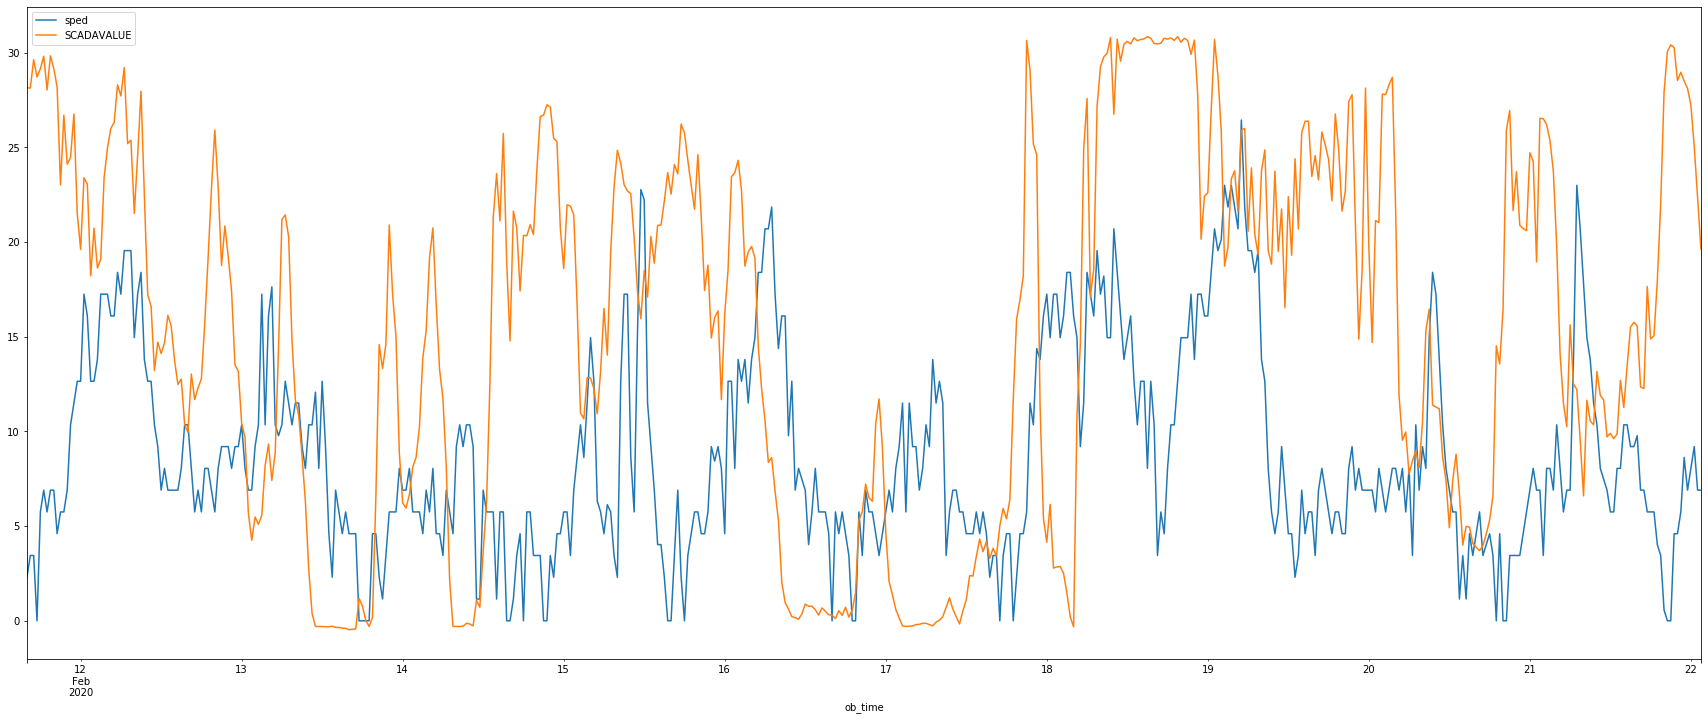

In [522]:
df = df_power_kia.merge(df_w_kia, left_index = True, right_index = True).iloc[:,[2,3,4,5,6,8,9]]
df.sped.iloc[8] = 14.2
df.iloc[:,:-1]=df.iloc[:,:-1].fillna(method = 'ffill')
df.iloc[2000:2500].loc[:,['sped','SCADAVALUE']].plot(figsize=(30,12))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11904 entries, 2020-01-01 00:00:00 to 2020-09-04 23:30:00
Freq: 30T
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SCADAVALUE  11904 non-null  float64
 1   lon         11904 non-null  float64
 2   lat         11904 non-null  float64
 3   tmpc        11904 non-null  float64
 4   relh        11904 non-null  float64
 5   sped        11904 non-null  float64
dtypes: float64(6)
memory usage: 651.0 KB


In [406]:
df_w_kia.index > datetime.datetime(2020, 8, 7)

array([False, False, False, ...,  True,  True,  True])

In [416]:
df_w_kia.resample('30T').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [386]:
df_power.DUID.isin(['asdf','WHILL1']).value_counts()

False    114049
Name: DUID, dtype: int64